In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import os
import pandas as pd
import scipy.stats
from matplotlib.gridspec import GridSpec
import sys
sys.path.insert(1, '../')
import my_utils as myf
import importlib
importlib.reload(myf)
plt.rcParams.update({'font.size': 12})
import glob

In [2]:
runmap = pd.read_csv('../e2.1runmap.csv',sep=',')
allens = runmap['names'].values

In [3]:
listds = []
for f in allens[:]:
    listds_i = []
    for var in ['sia','tos','sam']:
        listds_i.append(xr.open_mfdataset(myf.processed_dir+'timeseries/'+var+'/*'+f+'*.nc'))
    ds_i = xr.merge(listds_i).load().sel(region='50-65S')
    listds.append(ds_i)
ds = xr.concat(listds,dim='names').sel(time=slice('1979','2021'))

In [4]:
# add obs
list_obs = []
for var in ['sia','tos','sam']:
    myfiles = sorted(glob.glob(myf.processed_dir+'timeseries/'+var+'/*OB*'))
    myds = xr.open_mfdataset(myfiles,combine='nested',concat_dim='names')
    print(myds.names.values)
    list_obs.append(myds)
obs_ds = xr.merge(list_obs).sel(time=slice('1979','2021')).sel(region='50-65S')
obs_ds['time'] = ds.time.values

['OBS-CDRv4-bt' 'OBS-CDRv4-cdr' 'OBS-CDRv4-nt']
['OBS-ERSSTv5']
['OBS-MERRA2']


In [5]:
ds = xr.concat([ds,obs_ds],dim='names')

In [6]:
df = myf.plot_prop_from_names(ds.names.values)

OBS-CDRv4-bt
OBS-CDRv4-cdr
OBS-CDRv4-nt


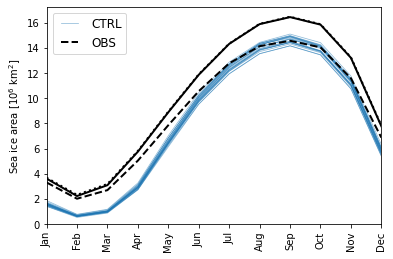

In [7]:
fig, ax = plt.subplots(1)
plt.rcParams.update({'font.size': 12})
for name in [f for f in ds.names.values if 'f1' in f or 'f2' in f]:
    ds.sel(names=name).groupby('time.month').mean(dim='time').sia_sh.plot(ax=ax,**df[name])
for n, name in enumerate([f for f in ds.names.values if 'OBS-CDR' in f]):
    print(name)
    ds.sel(names=name).groupby('time.month').mean(dim='time').sia_sh.plot(ax=ax,**df[name],linestyle=[':','-','--'][n])

ax.set_title('')
ax.set_ylabel('Sea ice area [10$^6$ km$^2$]')
ax.set_xlabel('')
ax.set_ylim(bottom=0)
ax.set_xlim([1,12])
ax.set_xticks(np.arange(1,13,1))
ax.set_xticklabels(myf.monthnames,rotation='vertical')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),numpoints=12)
fig.savefig('../figs/figS5.pdf',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

In [8]:
y1, y2 = 2004, 2020
# remove unnecessary runs
ds = ds.sel(names = [f for f in ds.names.values if 'OBS' in f or 'f5' in f or 'f6' in f])
myds = ds.sel(time=slice(str(y1),str(y2))).load()
myds = myds.drop('region')

In [9]:
datadir = myf.processed_dir+'timeseries/mlotst/'
myfiles = [f for f in sorted(os.listdir(datadir)) if '.nc' in f]
listds = []
for f in myfiles:
    m = xr.open_dataset(datadir+f).sel(time=slice(str(y1),str(y2))).load()
    m['time'] = myds.time.values
    m = m.set_coords('region')
    if 'region' in m.dims:
        m = m.sel(region='50-65S')
    listds.append(m)
mldds = xr.concat(listds,dim='names')

In [10]:
myds = xr.merge([mldds,myds])
df = myf.plot_prop_from_names(myds.names.values)

In [11]:
myds = myds.sel(names=['r1i1p1f5', 'r201i1p1f5','r202i1p1f5',
                       'r201i1p1f6',  'r202i1p1f6',
                       'OBS-ARGO', 'OBS-CDRv4-bt', 'OBS-CDRv4-cdr', 'OBS-CDRv4-nt',
                       'OBS-ERSSTv5', 'OBS-MERRA2'])

In [12]:
ds_clim = myds.groupby('time.month').mean('time')
ds_anom = myds.groupby('time.month') -  ds_clim

#don't compute anomaly for SAM - detrend it
ds_anom['SAM'] = myf.detrend(myds.time, myds.SAM, dim='time')

myds_smooth = ds_anom.rolling(time=3, center=True).mean()

# SAM normalized by sd of SAM before smoothing
myds_smooth['SAM'] = myds_smooth['SAM']/ds_anom['SAM'].std()

In [13]:
for name in ds.names.values:
    if 'f5' in name:
        pearson, corr = myf.pearson(myds_smooth['SAM'].sel(names='OBS-MERRA2'), 
                            myds_smooth['SAM'].sel(names=name), dim='time')
        print(name,pearson.values)

r1i1p1f5 0.9776824707920844
r201i1p1f5 0.9775313391289552
r202i1p1f5 0.9775385867995027


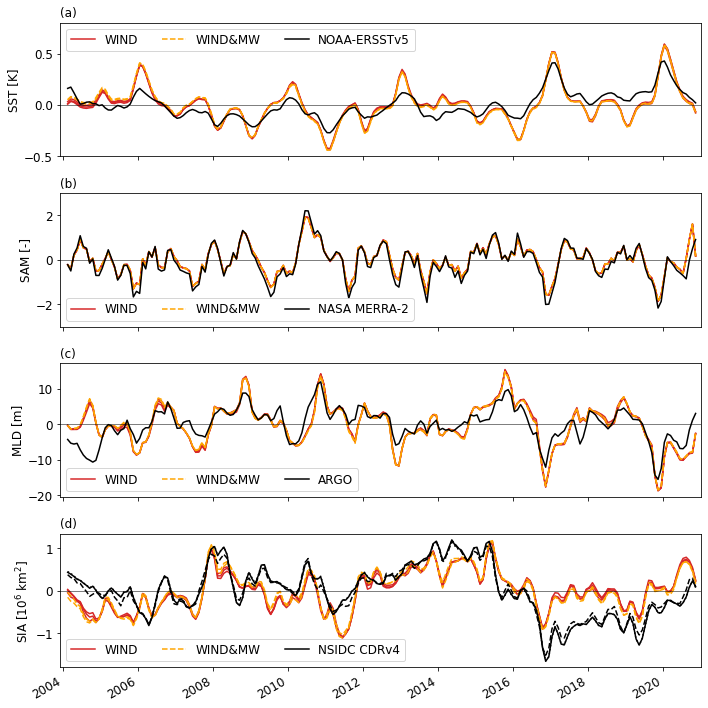

In [14]:
myvar = ['tos','SAM','mlotst', 'sia_sh']
varlabels = ['SST [K]','SAM [-]','MLD [m]','SIA [10$^6$ km$^2$]']
obsname = ['NOAA-ERSSTv5','NASA MERRA-2','ARGO','NSIDC CDRv4']

fig = plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 12})
for v, var in enumerate(myvar):
    ax = plt.subplot(len(myvar),1,v+1)

    for name in [f for f in myds.names.values if 'OBS' in f or 'f5' in f or 'f6' in f]:
        ls = '-'
        if 'f6' in name or '-nt' in name:
            ls = '--'
        if '-bt' in name:
            ls = ':'
        label = df[name]['label']
        if 'OBS' in label:
            label = obsname[v]
        myds_smooth[var].sel(names=name).plot(ax=ax,c=df[name]['c'],linestyle=ls,label=label,linewidth=1.5)
        
    ax.set_title('')
    ax.set_title(myf.alphabet[v],loc='left',fontsize=12)
    ax.set_xlabel('')
    ax.axhline(y=0,c='k',linewidth=0.5)
    if v<len(myvar)-1:
        ax.set_xticklabels('')
    ax.set_xlim(12171.05*1.018, .986*18901.9)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    if v==0:
        plt.legend(by_label.values(), by_label.keys(), loc='upper left',ncol=3)
    else:
        plt.legend(by_label.values(), by_label.keys(), loc='lower left',ncol=3)
    ax.set_ylabel(varlabels[v])
    if v==0:
        ax.set_ylim([-.5,.8])
    elif v==1:
        ax.set_ylim([-3,3])

plt.tight_layout()
fig.savefig('../figs/fig4.pdf',dpi=300,bbox_inches='tight')
plt.show()
plt.close()
